In [4]:
import pandas as pd 
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import norm, kurtosis, entropy, iqr, pearsonr
from sklearn.ensemble import RandomForestClassifier

In [5]:
li = []
for folder in os.listdir("data"):
    path = "data"+"/"+folder
    if os.path.isdir(path):
      for file in os.listdir(path):
        if file.endswith(".csv"): 
            df = pd.read_csv(path+"/"+file)
            df['state'] = folder
            li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame


,accelerometer_X,accelerometer_Y,accelerometer_Z,state
0,1.757344,-5.875371,-3.878607,running
1,2.461239,12.986150,1.762132,running
2,22.682667,22.922087,-1.738190,running
3,11.875240,4.611233,-8.389283,running
4,-5.295974,4.783615,-1.273715,running
...,...,...,...,...
193855,-4.137180,-4.429273,-1.517924,stairs
193856,1.829170,-9.313444,-0.330400,stairs
193857,-7.350199,-12.670115,-1.460463,stairs
193858,3.969586,-6.320692,9.255983,stairs


Step 1. Replacing name of state by numeric values 

In [6]:
dict  = {'running':2, 'idle':0, 'stairs':3, 'walking':1}
frame.replace({"state": dict}, inplace = True)
frame 

/var/folders/3f/rq0jv93j6mz9_0bxsplnhf4m0000gn/T/ipykernel_58338/745939523.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame.replace({"state": dict}, inplace = True)


,accelerometer_X,accelerometer_Y,accelerometer_Z,state
0,1.757344,-5.875371,-3.878607,2
1,2.461239,12.986150,1.762132,2
2,22.682667,22.922087,-1.738190,2
3,11.875240,4.611233,-8.389283,2
4,-5.295974,4.783615,-1.273715,2
...,...,...,...,...
193855,-4.137180,-4.429273,-1.517924,3
193856,1.829170,-9.313444,-0.330400,3
193857,-7.350199,-12.670115,-1.460463,3
193858,3.969586,-6.320692,9.255983,3


Building SVC classifier using time_features 

Step 1. Grouping data and calculationg time_features on segments

In [7]:
segments = (frame.index/30).astype(int)
time_features_df = frame.groupby(segments).agg({"accelerometer_X": ['min','max','mean','var','skew',kurtosis],
                                                "accelerometer_Y": [iqr,'mean','var','median','skew',kurtosis],
                                                "accelerometer_Z": [iqr,'mean','var','median','skew',kurtosis],
                                                "state":'min'})
time_features_df

accelerometer_X                                                       \
                 min        max      mean         var      skew  kurtosis   
0          -5.295974  27.087997  7.409416   76.998064  0.829433 -0.329635   
1          -7.656657  23.879768  5.468038   53.767946  0.927573  0.484702   
2          -5.224148  38.197090  7.893204  115.525614  1.309335  0.997580   
3          -8.729259  27.092787  6.006893   96.930381  0.707923 -0.494331   
4          -7.522581  38.197090  8.396306  119.531329  0.894111  0.227385   
...              ...        ...       ...         ...       ...       ...   
6457       -7.426813   5.272033 -0.268150   11.537731 -0.367549 -0.572317   
6458       -9.528923   5.272033 -0.410206   14.804948 -0.613766 -0.438638   
6459       -4.769250   5.880160  1.025197    7.708138 -0.064786 -0.689150   
6460      -10.036493   2.987964 -3.485958    9.810097 -0.292499 -0.350625   
6461      -11.238382   3.969586 -3.484042   14.242099 -0.260683 -0.514146   

     accelerometer_Y                                                        \
                 iqr       mean         var     median      skew  kurtosis   
0          20.253751   9.976958  146.789308  11.075577 -0.025404 -1.192542   
1          16.120159   6.951644   95.894508   7.012617  0.118284 -0.595865   
2          14.015657   8.591353  128.447666   9.004592 -0.096355 -0.886563   
3          34.766202   8.418812  329.678713   9.931148 -0.097170 -1.160555   
4          20.974404   9.223423  172.722327   9.471462 -0.065126 -1.048682   
...              ...        ...         ...        ...       ...       ...   
6457        6.975506 -11.872208   35.448681 -11.314997 -0.342626  0.091885   
6458        6.491878 -12.038365   39.446280 -11.427525 -0.256711 -0.303102   
6459        3.396175  -8.778580   10.909678  -8.219295 -0.675586 -0.109818   
6460        5.728128  -9.529082   20.769973 -10.728418  0.558266 -0.164386   
6461        7.461529  -8.297824   25.703086  -9.217676  0.392981 -0.713873   

     accelerometer_Z                                                    state  
                 iqr      mean        var    median      skew  kurtosis   min  
0           5.573702 -0.256978  29.532704 -1.218649  0.537773 -0.363087     2  
1           8.799889  1.152409  50.960619  0.842759  0.085068 -0.586764     2  
2           7.704540 -0.739170  90.935806 -2.693477  1.157902  2.966579     2  
3           5.309142 -0.534066  26.470942 -1.651999  0.968007  1.269185     2  
4           9.807847  2.074177  80.609107 -1.058237  1.287839  1.905838     2  
...              ...       ...        ...       ...       ...       ...   ...  
6457        5.505467 -2.679910  38.573650 -2.545036 -1.053054  2.127992     3  
6458        5.949591 -2.939122  40.125068 -2.308010 -1.231690  1.566871     3  
6459        3.495534 -2.715025  28.876039 -2.329558 -1.763326  5.207819     3  
6460        3.233370 -1.474190   6.371714 -1.319205 -0.773115  0.168998     3  
6461        2.406173 -0.513955  16.207553 -0.814029 -0.290261  3.182636     3  

[6462 rows x 19 columns]

Step 2. Scaling data

In [8]:
X = time_features_df.iloc[:,0:-1]
y = time_features_df.iloc[:,-1]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[ 0.53459672,  0.79943177,  1.19455363, ..., -0.72100576,
         0.20493249, -0.76081678],
       [ 0.19349233,  0.56490679,  0.77181628, ..., -0.15251637,
        -0.1633537 , -0.82759813],
       [ 0.54497514,  1.61151838,  1.29989907, ..., -1.12772999,
         0.70942175,  0.23329274],
       ...,
       [ 0.61070515, -0.75088386, -0.19561727, ..., -1.02736939,
        -1.66706471,  0.90244037],
       [-0.15037955, -0.96230648, -1.17792641, ..., -0.74873696,
        -0.86150473, -0.60195694],
       [-0.32404523, -0.89054886, -1.17750932, ..., -0.60942075,
        -0.46869198,  0.2977991 ]])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_set_index ,test_set_index in splitter.split(X_scaled, y):
    train_set_X = X_scaled[train_set_index]
    train_set_y = y[train_set_index]
    test_set_y = y[test_set_index]
    test_set_X = X_scaled[test_set_index]


Step 3. Model fitting and prediction making with SVC classifier 

In [7]:
classifier = SVC(kernel='linear')
classifier.fit(train_set_X, train_set_y)

y_predicted = classifier.predict(test_set_X)

Building SVC classifier using accelerometer data

Step 1. Splitting data on training and test set

In [19]:
X_1 = frame.iloc[:,0:-1].values
y_1 = frame.iloc[:,-1].values
from sklearn.model_selection import StratifiedShuffleSplit

splitter_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_set_index ,test_set_index in splitter_1.split(X_1 , y_1 ):

    train_set_X_1 = X_1[train_set_index ]
    train_set_y_1 = y_1[train_set_index ]
    test_set_y_1 = y_1[test_set_index ]
    test_set_X_1 = X_1[test_set_index  ]

X_1

array([[  1.757344,  -5.875371,  -3.878607],
       [  2.461239,  12.98615 ,   1.762132],
       [ 22.682667,  22.922087,  -1.73819 ],
       ...,
       [ -7.350199, -12.670115,  -1.460463],
       [  3.969586,  -6.320692,   9.255983],
       [  1.747767,   2.920926,   7.910443]])

Step 2. Model fitting and prediction making with SVC classifier 

In [36]:
classifier_1 = SVC(kernel='linear')
classifier_1.fit(train_set_X_1, train_set_y_1)

y_predicted_1 = classifier_1.predict(test_set_X_1)

Evaluating results of models

Classification report for SVC fitted on dataset with time_features

In [1]:
from sklearn.metrics import classification_report

print(classification_report(test_set_y, y_predicted))

NameError: name 'test_set_y' is not defined

Classification report for SVC fitted on dataset without time_features

In [38]:

print(classification_report(test_set_y_1, y_predicted_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9351
           1       1.00      1.00      1.00     16650
           2       1.00      1.00      1.00     30672
           3       1.00      1.00      1.00      1485

    accuracy                           1.00     58158
   macro avg       1.00      1.00      1.00     58158
weighted avg       1.00      1.00      1.00     58158



Random forest

In [24]:
 
clf_time_features = RandomForestClassifier(max_depth=4, random_state=42)
clf_time_features.fit(train_set_X, train_set_y)
y_predicted = clf_time_features.predict(test_set_X)
print(classification_report(test_set_y ,y_predicted))
     

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.93      1.00      0.96       555
           2       1.00      1.00      1.00      1023
           3       1.00      0.08      0.15        49

    accuracy                           0.98      1939
   macro avg       0.98      0.77      0.78      1939
weighted avg       0.98      0.98      0.97      1939



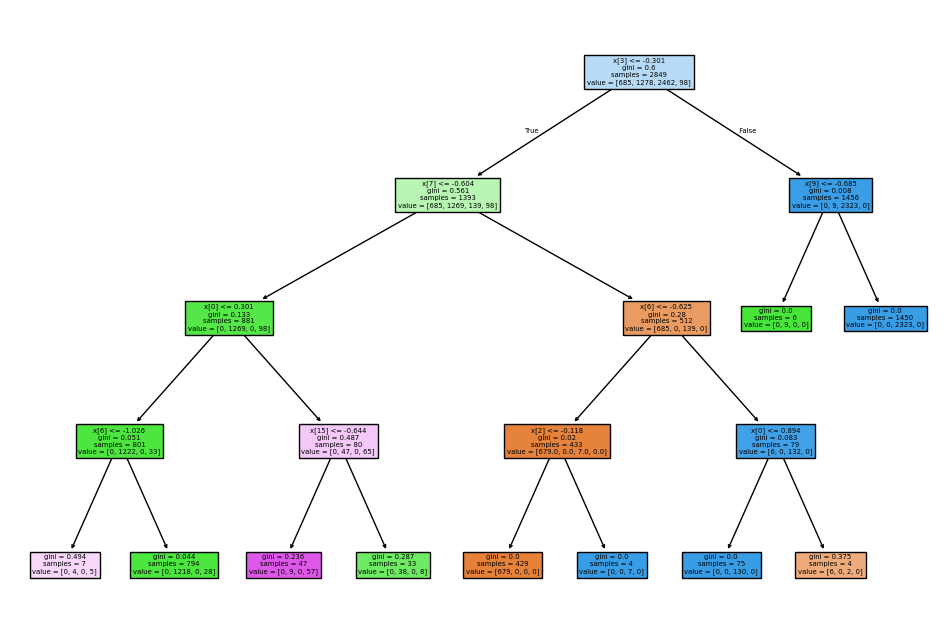

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

individual_tree = clf_time_features.estimators_[0] 
plt.figure(figsize=(12, 8))
plot_tree(individual_tree, filled=True)
plt.show()

In [23]:
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(train_set_X_1, train_set_y_1)
y_predicted = clf.predict(test_set_X_1)
print(classification_report(test_set_y_1,y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      9351
           1       0.81      0.85      0.83     16650
           2       0.89      0.92      0.91     30672
           3       0.00      0.00      0.00      1485

    accuracy                           0.88     58158
   macro avg       0.67      0.68      0.68     58158
weighted avg       0.86      0.88      0.87     58158



/Users/anastsiasmirnova/.local/share/virtualenvs/PythonScripts-1qN182z3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anastsiasmirnova/.local/share/virtualenvs/PythonScripts-1qN182z3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anastsiasmirnova/.local/share/virtualenvs/PythonScripts-1qN182z3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

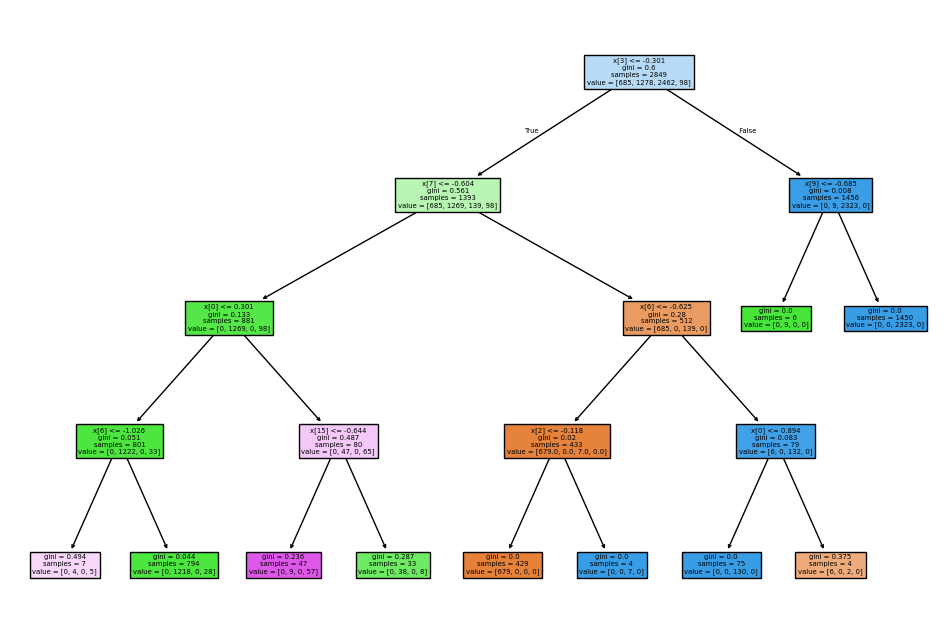

In [21]:
individual_tree_1 = clf.estimators_[0] 
plt.figure(figsize=(12, 8))
plot_tree(individual_tree, filled=True)
plt.show()

Отже, виходячи з отриманих репортів, можна зробити висновок що метрики якості для моделей з використанням time_features набагато вище за метрики якості моделей, які навчалась на даних без розрахунку time_features. Причому є важливим відмітити, що у випадку з моделями побудованих на основі датасету тільки з використанням показників акселерометру дуже низькими є показники якості моделі для 4 класу, тобто ходьба по сходах